## Project : Fine tuning of GPT-2 for Text Generation

## Problem Statement


### Algorithms in the field of Artificial Intelligence are being developed rapidly and there are many large language models available right now for multiple purposes. These models are trained on a very large corpus of datasets from various fields and subjects. What if we want to use it for any one purpose? Training a new model for a specific purpose and field requires a very large dataset, time and huge computational power. Solution to this problem is fine-tuning of pretrained large models. Fine-tuning means to train a pre-trained model further using a dataset of specific context or domain. This solution will be demonstrated and explored in this project.


## Aim

### This project aims to fine tune a large language model on Harry Potter books dataset in a way that it can generate text related to Harry Potter books and movies from the provided prompt. Hyperparameters learning rate and epochs will be explored after fine tuning of the model.

In [2]:
#!pip install transformers xformers accelerate
import torch
import re
from tqdm import tqdm
from torch.utils.data import DataLoader, Dataset
from transformers import GPT2LMHeadModel, GPT2Tokenizer
from torch.optim import AdamW
from transformers import Trainer, TrainingArguments
from transformers import TextDataset, DataCollatorForLanguageModeling
from transformers import pipeline, set_seed
import matplotlib.pyplot as plt
%matplotlib inline

## Model Selection

### GPT-2 (Generative pretrained transformer) open source model by OpenAi will be used in this project. It was trained on a corpus of ~40 GB of text data. It is a large language model with 1.5 billion parameters with the objective to predict the next word from given words as a prompt and that is why this model is perfect to explore as it aligns with the project goal.


#### In the cell below, GPT2 model is used before fine tuning for text generation using prompt word "Harry". As we can see generated text is not related to Harry Potter. 

In [ ]:
# Generate text example using gpt2 model
generator = pipeline('text-generation', model='gpt2')
set_seed(101)
generator("Harry", max_length=30, num_return_sequences=2)


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[{'generated_text': 'Harry had shown no interest in the issue of sex trafficking in his own name. Rather, he was the only one of the four members of the party'},
 {'generated_text': 'Harry was like, "Uh, there\'s nothing to keep me from writing it?" "I can find a way to tell you that, right here'}]

## Data Collection and Preprocessing

### Data was collected from a github repository. As we are fine tuning a model for text generation, the entire data is in text format containing text script of seven books of Harry Potter series. “Re" module of Python was used to preprocess the text dataset as defined steps below: 
1. All values except alphabetic character, numeric, white space or underscore were removed from text.
2. Any multiple consecutive whitespaces were replaced with just one whitespace.
3. Any leading or trailing whitespace was removed from the text dataset.
### This preprocessed dataset was stored in a single text file for further use.


In [3]:
#Data Loading and Data Cleaning
script_files = ["./data/Book 1.txt","./data/Book 2.txt","./data/Book 3.txt","./data/Book 4.txt","./data/Book 5.txt",
                "./data/Book 6.txt","./data/Book 7.txt"]
text_data=""
for script in script_files:
    with open(script, 'r', encoding='utf-8') as file:
        text = file.read()
        text = re.sub(r"[^\w\s]", "", text)
        text = re.sub(r"\s+", " ", text)
        text_data=text_data+text
        text_data = text_data.strip()
        file.close()
#Save cleaned data in a text file
data_file = open('./data/cleaned_text_data.txt', 'w')
data_file.write(text_data)
data_file.close()

In [4]:
#Location of cleaned data
data_file='./data/cleaned_text_data.txt'

In [5]:
#Size of text data
len(text_data)

6182371

In [ ]:
#Load the tokenizer for GPT2 model
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
#Tokenize the dataset
dataset = TextDataset(tokenizer=tokenizer,file_path=data_file,block_size=128)

data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer,mlm=False)
## This block of code will be included in defined functions below.

/usr/local/lib/python3.10/dist-packages/transformers/data/datasets/language_modeling.py:53: FutureWarning: This dataset will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/language-modeling/run_mlm.py
  warnings.warn(


## Define Required Functions

### Various Class and functions of transformers libraries were used to tokenize and load the dataset to fine tune the model. GPT2Tokenizer was used to tokenize the pre-processed text data. Tokenizations break down text data into tokens which are input for the model in the training process and that is why it is a crucial step in natural language processing tasks. GPT-2 model was loaded using the GPT2LMHeadModel class of transformers.

In [6]:
#Define function to load and tokenize the dataset
def load_dataset(file_path, tokenizer, block_size = 128):
    dataset = TextDataset(
        tokenizer = tokenizer,
        file_path = file_path,
        block_size = block_size,
    )
    return dataset

#Function to load data collator for language modelling
def load_data_collator(tokenizer, mlm = False):
    data_collator = DataCollatorForLanguageModeling(
        tokenizer=tokenizer, 
        mlm=mlm,
    )
    return data_collator

#Function to train the model
def train(train_file_path,model_name,output_dir,overwrite_output_dir,
          per_device_train_batch_size,
          num_train_epochs,learning_rate):
    
    tokenizer = GPT2Tokenizer.from_pretrained(model_name)
    train_dataset = load_dataset(train_file_path, tokenizer)
    data_collator = load_data_collator(tokenizer)

    tokenizer.save_pretrained(output_dir)

    model = GPT2LMHeadModel.from_pretrained(model_name)

    #Define training arguments
    training_args = TrainingArguments(
        output_dir=output_dir,
        overwrite_output_dir=overwrite_output_dir,
        per_device_train_batch_size=per_device_train_batch_size,
        num_train_epochs=num_train_epochs,logging_steps=100, learning_rate = learning_rate)
    #Trainer function to train the model        
    trainer = Trainer(model=model,args=training_args,data_collator=data_collator,train_dataset=train_dataset)

    trainer.train()
    #Save the model
    trainer.save_model()
    return trainer



## References
#### 1. https://huggingface.co/docs/transformers/main_classes/pipelines#transformers.pipeline.model
#### 2. https://huggingface.co/docs/transformers/main_classes/trainer
#### 3. GPT-2 available at chat.openai.com for more understanding of arguments. 

### Fine tune GPT-2 model with learning rate 0.0001 (Model 1)

In [ ]:
#Setting parameters
train_file_path = data_file
model_name = 'gpt2'
output_dir = 'saved_model'
overwrite_output_dir = True
per_device_train_batch_size = 32
num_train_epochs = 10
learning_rate = 0.0001

In [ ]:
#Calling train function to train the model
print("Learning Rate = ", learning_rate)
trainer = train(train_file_path=train_file_path,model_name=model_name,
                output_dir=output_dir,
                overwrite_output_dir=overwrite_output_dir,
                per_device_train_batch_size=per_device_train_batch_size,
                num_train_epochs=num_train_epochs, learning_rate=learning_rate)

Learning Rate =  0.0001


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss
100,4.176000
200,3.958600
300,3.882500
400,3.722300
500,3.690900
600,3.668900
700,3.552100
800,3.517200
900,3.515500
1000,3.430500


### Visualize the training logs for Model 1

In [ ]:
#Print the model training logs
trainer.state.log_history

[{'loss': 4.176,
  'learning_rate': 9.678456591639872e-05,
  'epoch': 0.32,
  'step': 100},
 {'loss': 3.9586,
  'learning_rate': 9.356913183279743e-05,
  'epoch': 0.64,
  'step': 200},
 {'loss': 3.8825,
  'learning_rate': 9.035369774919614e-05,
  'epoch': 0.96,
  'step': 300},
 {'loss': 3.7223,
  'learning_rate': 8.713826366559486e-05,
  'epoch': 1.29,
  'step': 400},
 {'loss': 3.6909,
  'learning_rate': 8.392282958199358e-05,
  'epoch': 1.61,
  'step': 500},
 {'loss': 3.6689,
  'learning_rate': 8.07073954983923e-05,
  'epoch': 1.93,
  'step': 600},
 {'loss': 3.5521,
  'learning_rate': 7.749196141479101e-05,
  'epoch': 2.25,
  'step': 700},
 {'loss': 3.5172,
  'learning_rate': 7.427652733118972e-05,
  'epoch': 2.57,
  'step': 800},
 {'loss': 3.5155,
  'learning_rate': 7.106109324758843e-05,
  'epoch': 2.89,
  'step': 900},
 {'loss': 3.4305,
  'learning_rate': 6.784565916398715e-05,
  'epoch': 3.22,
  'step': 1000},
 {'loss': 3.3944,
  'learning_rate': 6.463022508038586e-05,
  'epoch': 

In [ ]:
#Store steps, loss and epochs data from training logs
steps = []
loss =[]
epochs=[]
for i in range(len(trainer.state.log_history)):
    steps.append(trainer.state.log_history[i]["step"])
for i in range(len(trainer.state.log_history)):
    epochs.append(trainer.state.log_history[i]["epoch"])


In [ ]:
for i in range(len(trainer.state.log_history)-1):
    loss.append(trainer.state.log_history[i]["loss"])
loss.append(trainer.state.log_history[len(trainer.state.log_history)-1]["train_loss"])

In [ ]:
print(epochs,steps, loss)

[0.32, 0.64, 0.96, 1.29, 1.61, 1.93, 2.25, 2.57, 2.89, 3.22, 3.54, 3.86, 4.18, 4.5, 4.82, 5.14, 5.47, 5.79, 6.11, 6.43, 6.75, 7.07, 7.4, 7.72, 8.04, 8.36, 8.68, 9.0, 9.32, 9.65, 9.97, 10.0] [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900, 2000, 2100, 2200, 2300, 2400, 2500, 2600, 2700, 2800, 2900, 3000, 3100, 3110] [4.176, 3.9586, 3.8825, 3.7223, 3.6909, 3.6689, 3.5521, 3.5172, 3.5155, 3.4305, 3.3944, 3.394, 3.3331, 3.2879, 3.2999, 3.248, 3.2201, 3.2054, 3.1887, 3.1305, 3.151, 3.1261, 3.0819, 3.0881, 3.0915, 3.0442, 3.0514, 3.0535, 3.0214, 3.0193, 3.0234, 3.339925689942584]


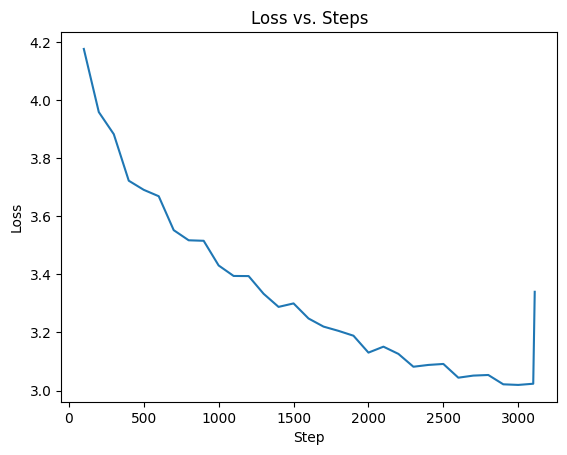

In [ ]:
#Plot the graph of training loss vs steps
plt.plot(steps, loss)
plt.xlabel("Step")
plt.ylabel("Loss")
plt.title("Loss vs. Steps")
plt.show()

### Both charts represents that with increasing step size and epochs loss is decreasing and at last its increasing. SO, it is recommended to use callbacks for early stopping to stop where loss is minimum. Minimum training loss value we got for learning rate = 0.0001 is 3.0193

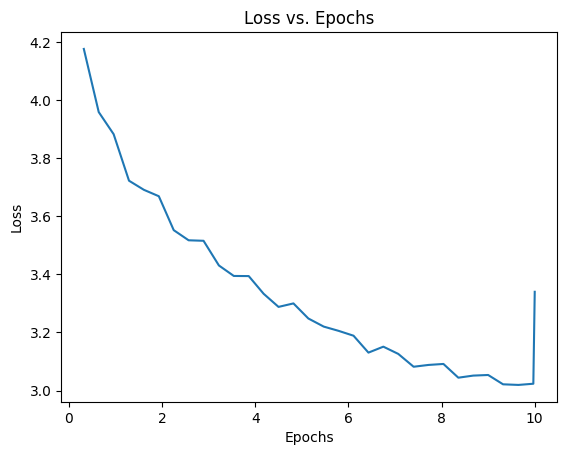

In [ ]:
#Plot the graph of training loss vs epochs
plt.plot(epochs, loss)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss vs. Epochs")
plt.show()

### Model Evaluation (Model 1)

In [ ]:
# Generate text example
generator = pipeline('text-generation', model="./saved_model")
generator("Harry", max_length=30, num_return_sequences=2)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[{'generated_text': 'Harry he said softly Ive told him youve been wanting him for a year Ron whispered Harry stared up into Hermiones face and her hair fell'},
 {'generated_text': 'Harry have heard of him Dumbledore said hastily Page 639Harry Potter and the Order of the Phoenix JK Rowling Yes said Harry quietly Dumbledore is still at'}]

### Here again prompt text "Harry" was used to generate text from fine tuned GPT 2 model and we can notice that both of sequences are related to Harry Potter and Hogwartz which shows that our fine tuning process is successful.

In [ ]:
#Generate text example
generator("Hogwarts", max_length=100, num_return_sequences=1)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[{'generated_text': 'Hogwarts and the Half Blood Prince JK Rowling You can use magic as you like said Dumbledore But Harry had never tried this before He and Ron stared at him It feels strange said Dumbledore And he said youve got the power to hex people He opened his mouth to answer a question Harry had not expected at all After all he had known too late that he was going to see Voldemort again and that he had fought that battle on the Hogwarts Express He glanced toward the windows as they passed in the Great'}]

### Fine tune model with learning rate 0.001 (Model 2)

In [10]:
#Setting parameters
train_file_path = data_file
model_name = 'gpt2'
output_dir = 'saved_model1'
overwrite_output_dir = True
per_device_train_batch_size = 32
num_train_epochs = 10
learning_rate = 0.001

In [11]:
#Calling train function to train the model
print("Learning Rate = ", learning_rate)
trainer1 = train(train_file_path=train_file_path,model_name=model_name,
                output_dir=output_dir,
                overwrite_output_dir=overwrite_output_dir,
                per_device_train_batch_size=per_device_train_batch_size,
                num_train_epochs=num_train_epochs, learning_rate=learning_rate)

Learning Rate =  0.001


Step,Training Loss
100,4.385500
200,4.023700
300,3.920500
400,3.494000
500,3.485400
600,3.480600
700,3.070800
800,3.040600
900,3.080900
1000,2.711100


In [12]:
#Print the model training logs
trainer1.state.log_history

[{'loss': 4.3855,
  'learning_rate': 0.0009678456591639871,
  'epoch': 0.32,
  'step': 100},
 {'loss': 4.0237,
  'learning_rate': 0.0009356913183279742,
  'epoch': 0.64,
  'step': 200},
 {'loss': 3.9205,
  'learning_rate': 0.0009035369774919614,
  'epoch': 0.96,
  'step': 300},
 {'loss': 3.494,
  'learning_rate': 0.0008713826366559485,
  'epoch': 1.29,
  'step': 400},
 {'loss': 3.4854,
  'learning_rate': 0.0008392282958199357,
  'epoch': 1.61,
  'step': 500},
 {'loss': 3.4806,
  'learning_rate': 0.0008070739549839228,
  'epoch': 1.93,
  'step': 600},
 {'loss': 3.0708,
  'learning_rate': 0.00077491961414791,
  'epoch': 2.25,
  'step': 700},
 {'loss': 3.0406,
  'learning_rate': 0.0007427652733118971,
  'epoch': 2.57,
  'step': 800},
 {'loss': 3.0809,
  'learning_rate': 0.0007106109324758842,
  'epoch': 2.89,
  'step': 900},
 {'loss': 2.7111,
  'learning_rate': 0.0006784565916398713,
  'epoch': 3.22,
  'step': 1000},
 {'loss': 2.6094,
  'learning_rate': 0.0006463022508038586,
  'epoch': 3

In [13]:
#Store steps, loss and epochs data from training logs
steps1 = []
loss1 =[]
epochs1=[]
for i in range(len(trainer1.state.log_history)):
    steps1.append(trainer1.state.log_history[i]["step"])
for i in range(len(trainer1.state.log_history)):
    epochs1.append(trainer1.state.log_history[i]["epoch"])


In [14]:
for i in range(len(trainer1.state.log_history)-1):
    loss1.append(trainer1.state.log_history[i]["loss"])
loss1.append(trainer1.state.log_history[len(trainer1.state.log_history)-1]["train_loss"])

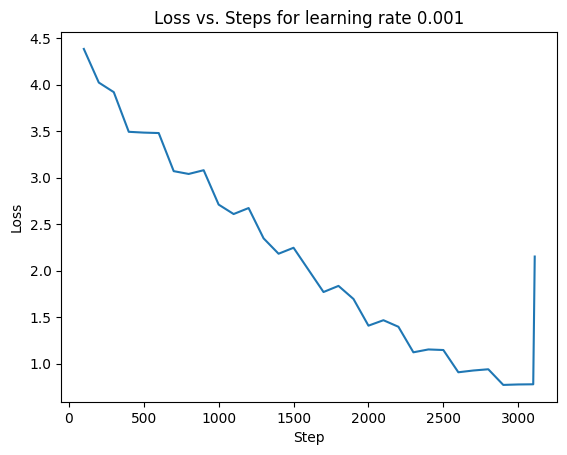

In [15]:
#Plot the graph of training loss vs steps
plt.plot(steps1, loss1)
plt.xlabel("Step")
plt.ylabel("Loss")
plt.title("Loss vs. Steps for learning rate 0.001")
plt.show()

### Both charts represents that with increasing step size and epochs loss is decreasing and at last its increasing. So, it is recommended to use callbacks for early stopping to stop where loss is minimum. Minimum training loss value we got for learning rate = 0.001 is 0.7714  which is much lower than learning rate 0.0001. So, we can say that learning rate 0.001 worked more efficiently for 10 epochs in reducing training loss and recommend to use this value of learning rate.

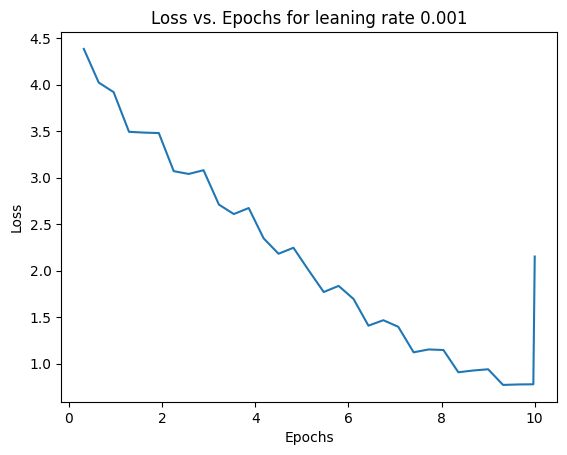

In [16]:
#Plot the graph of training loss vs epochs
plt.plot(epochs1, loss1)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss vs. Epochs for leaning rate 0.001")
plt.show()

### Model evaluation (Model 2)

In [21]:
# Generate text example
generator = pipeline('text-generation', model="./saved_model1")
generator("Harry", max_length=30, num_return_sequences=2)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[{'generated_text': 'Harry Potter and the Order of the Phoenix JK Rowling The carriage set off atacross in earnest swaying very slightly in the air Harry listened as'},
 {'generated_text': 'Harry was struggling against a backdrop of grimy blackandwhite photographs He tried to draw breath but it made his head spin and his breathing heavy Professor p'}]

### Here again text prompts "Harry" and "Hogwarts" were used to test the fine tuned model with learning rate 0.001 and as we can see both worked.

In [18]:
#Generate text example
generator("Hogwarts", max_length=100, num_return_sequences=1)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[{'generated_text': 'Hogwarts cant be allowed out unless Sturgis Podmore who was supposed to be an old fraud has denied he ever had contact with Dumbledore There was a stunned silence Harry felt as though the final straw had died a little now it was too late Well there you have it Snape swept off his desk and stood staring at Harry without flinching I just wondered if there could be any way of getting it out of the castle once the thing was caught could there said Harry in surprise Maybe if we could'}]

### Using very high computational power, one can furthermore optimize this model to generate texts related to specific content or context.